In [1]:
import string

import faceted
import fsspec
import numpy as np
import xarray as xr

from upath import UPath

import plotting
import utils
from constants import CLIMATES

In [2]:
plotting.configure_style()

In [3]:
catalog = utils.open_catalog()
REFERENCE = "SHiELD-SOM-C96"
BASELINE = "SHiELD-SOM-C24-tuned-cdmbgwd"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"
MODELS = [REFERENCE, BASELINE, ACE2_SOM]

In [4]:
cases = catalog[(catalog["forcing"] == "increasing-CO2") & catalog["model"].isin(MODELS)]

In [5]:
datasets = {}
for _, case in cases.iterrows():
    model = case["model"]
    beaker_id = case["beaker_id"]
    datasets[model] = utils.open_beaker_dataset(beaker_id, "annual_diagnostics.nc")
ds = utils.dict_to_dataset(datasets, "model").sel(source="prediction").drop("source")
ds = utils.scale_precipitation(ds)

Output()

Output()

Output()

/tmp/ipykernel_4922/2246624786.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = utils.dict_to_dataset(datasets, "model").sel(source="prediction").drop("source")


In [6]:
LABELS = {
    "surface_temperature": "Global annual mean\nsurface temperature [K]",
    "PRATEsfc": "Global annual mean\nprecipitation [mm/day]",
    "air_temperature_0": "Global annual mean\nair_temperature_0 [K]",
    "specific_total_water_0": "Global annual mean\nspecific_total_water_0 [kg/kg]"
}

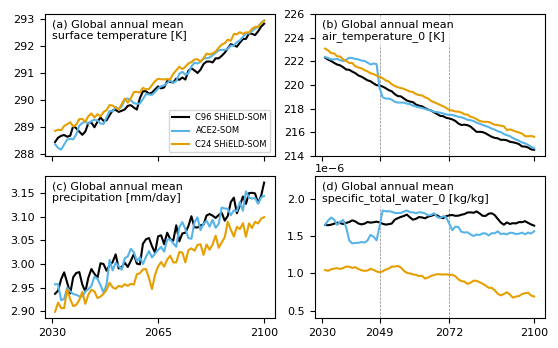

In [16]:
fig, axes = faceted.faceted(
    2,
    2,
    width=5.5,
    aspect=0.618,
    internal_pad=(0.4, 0.2),
    sharey=False,
    left_pad=0.4,
    top_pad=0.1,
    right_pad=0.1,
    sharex=False
)

ax1, ax2, ax3, ax4 = axes

for ax, variable, letter in zip(axes, ["surface_temperature", "air_temperature_0", "PRATEsfc", "specific_total_water_0"], string.ascii_lowercase):
    ds.sel(model=REFERENCE)[variable].plot(ax=ax, color="k", label="C96 SHiELD-SOM")
    ds.sel(model=ACE2_SOM)[variable].plot(ax=ax, color="C0", label="ACE2-SOM")
    ds.sel(model=BASELINE)[variable].plot(ax=ax, color="C1", label="C24 SHiELD-SOM")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    if variable in ["air_temperature_0", "specific_total_water_0"]:
        ax.set_xticks([2030, 2049, 2072, 2100])
        ax.axvline(2049, color="gray", ls="--", lw=0.5, zorder=0)
        ax.axvline(2072, color="gray", ls="--", lw=0.5, zorder=0)
    else:
        ax.set_xticks([2030, 2065, 2100])

    ax.annotate(
        f"({letter}) {LABELS[variable]}", 
        xy=(0.02, 0.98), 
        xytext=(2, -2), 
        va="top", 
        xycoords="axes fraction",
        textcoords="offset points",
        bbox=dict(facecolor="w", edgecolor="none", boxstyle="round", alpha=0.75)
    )

    if variable == "surface_temperature":
        ax.legend(loc="lower right", fontsize=6)

ax2.set_ylim([214, 226])
ax4.set_ylim([0.4e-6, 2.3e-6])

ax1.set_xticklabels([])
ax2.set_xticklabels([])

fig.savefig("figures/figure-07.pdf")
fig.savefig("figures/figure-07.png", dpi=200)

In [8]:
1 / (ds.sel(model=BASELINE).specific_total_water_0.min() / ds.sel(model=BASELINE).specific_total_water_0.max())

<xarray.DataArray 'specific_total_water_0' ()> Size: 8B
array(1.62746319)
Coordinates:
    model    <U28 112B 'SHiELD-SOM-C24-tuned-cdmbgwd'

In [9]:
ds.sel(model=BASELINE).specific_total_water_0.isel(year=-1)

<xarray.DataArray 'specific_total_water_0' (sample: 1)> Size: 8B
array([6.90864495e-07])
Coordinates:
    year     int64 8B 2100
    model    <U28 112B 'SHiELD-SOM-C24-tuned-cdmbgwd'
Dimensions without coordinates: sample

In [10]:
abs(ds.air_temperature_0.sel(model=ACE2_SOM).diff("year")).argmax()

<xarray.DataArray 'air_temperature_0' ()> Size: 8B
array(17)
Coordinates:
    model    <U26 104B 'ACE2-SOM-multi-climate-RS3'

In [11]:
abs(ds.specific_total_water_0.sel(year=2049, model=ACE2_SOM).diff("year")).argmax()

<xarray.DataArray 'specific_total_water_0' ()> Size: 8B
array(0)
Coordinates:
    year     int64 8B 2049
    model    <U26 104B 'ACE2-SOM-multi-climate-RS3'

In [12]:
ds.specific_total_water_0.sel(year=slice(2049, None), model=ACE2_SOM).diff("year").isel(year=22)

<xarray.DataArray 'specific_total_water_0' (sample: 1)> Size: 8B
array([-8.43984857e-08])
Coordinates:
    year     int64 8B 2072
    model    <U26 104B 'ACE2-SOM-multi-climate-RS3'
Dimensions without coordinates: sample

In [13]:
abs(ds.air_temperature_0.sel(model=ACE2_SOM).diff("year")).argmax()

<xarray.DataArray 'air_temperature_0' ()> Size: 8B
array(17)
Coordinates:
    model    <U26 104B 'ACE2-SOM-multi-climate-RS3'

In [14]:
NOISE_FLOOR_DATA_TEMPLATE = "gs://vcm-ml-intermediate/2024-08-09-vertically-resolved-1deg-c96-shield-som-{climate}-dataset-noise-floor"


def load_annual_means(climate):
    path = UPath(NOISE_FLOOR_DATA_TEMPLATE.format(climate=climate)) / "annual_means.nc"
    fs, *_ = fsspec.get_fs_token_paths(path)
    return utils.open_remote_nc(fs, str(path)).load()


def load_training_data_ensemble_means(climate):
    ds = load_annual_means(climate)
    result = ds.isel(sample=slice(None, 4)).mean(["sample", "year"]).load()
    return result.rename({"grid_xt": "lon", "grid_yt": "lat"})


def load_reference():
    datasets = {}
    for climate in CLIMATES:
        ensemble_means = load_training_data_ensemble_means(climate)
        datasets[climate] = ensemble_means
    result = utils.dict_to_dataset(datasets, dim="climate")
    return utils.scale_precipitation(result).assign_coords(model=REFERENCE)

In [15]:
reference = load_reference()
global_mean_reference = reference[["specific_total_water_0", "air_temperature_0"]].weighted(np.cos(np.deg2rad(reference.lat))).mean(["lon", "lat"])
increasing_co2_dataset = xr.open_zarr("gs://vcm-ml-intermediate/2024-07-16-vertically-resolved-4deg-c96-shield-som-increasing-co2-fme-dataset/increasing-CO2.zarr")
co2 = increasing_co2_dataset.global_mean_co2.resample(time="YS").mean().isel(time=slice(None, -1)).compute()
global_mean_reference = global_mean_reference.assign_coords(climate=363.43 * np.array([1, 2, 3, 4]))
co2 = co2.assign_coords(time=co2.time.dt.year).rename({"time": "year"})

[Text(2030, 0, ''), Text(2049, 0, ''), Text(2072, 0, ''), Text(2100, 0, '')]

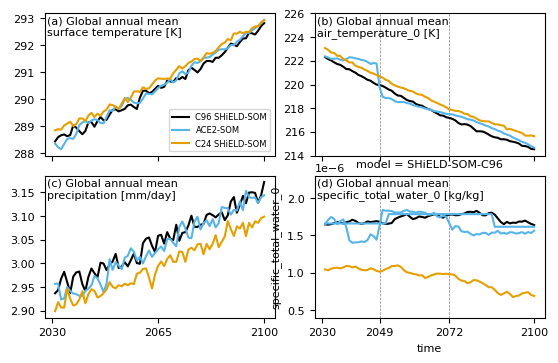

In [16]:
fig, axes = faceted.faceted(
    2,
    2,
    width=5.5,
    aspect=0.618,
    internal_pad=(0.4, 0.2),
    sharey=False,
    left_pad=0.4,
    top_pad=0.1,
    right_pad=0.1,
    sharex=False
)

ax1, ax2, ax3, ax4 = axes

for ax, variable, letter in zip(axes, ["surface_temperature", "air_temperature_0", "PRATEsfc", "specific_total_water_0"], string.ascii_lowercase):
    ds.sel(model=REFERENCE)[variable].plot(ax=ax, color="k", label="C96 SHiELD-SOM")
    ds.sel(model=ACE2_SOM)[variable].plot(ax=ax, color="C0", label="ACE2-SOM")
    ds.sel(model=BASELINE)[variable].plot(ax=ax, color="C1", label="C24 SHiELD-SOM")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    if variable in ["air_temperature_0", "specific_total_water_0"]:
        ax.set_xticks([2030, 2049, 2072, 2100])
        ax.axvline(2049, color="gray", ls="--", lw=0.5, zorder=0)
        ax.axvline(2072, color="gray", ls="--", lw=0.5, zorder=0)
    else:
        ax.set_xticks([2030, 2065, 2100])

    if variable == "specific_total_water_0":
        global_mean_reference.drop_isel(climate=2).specific_total_water_0.sel(climate=co2 * 1000000, method="nearest").plot(ax=ax)

    ax.annotate(
        f"({letter}) {LABELS[variable]}", 
        xy=(0, 1), 
        xytext=(2, -2), 
        va="top", 
        xycoords="axes fraction",
        textcoords="offset points"
    )

    if variable == "surface_temperature":
        ax.legend(loc="lower right", fontsize=6)

ax2.set_ylim([214, 226])
ax4.set_ylim([0.4e-6, 2.3e-6])

ax1.set_xticklabels([])
ax2.set_xticklabels([])

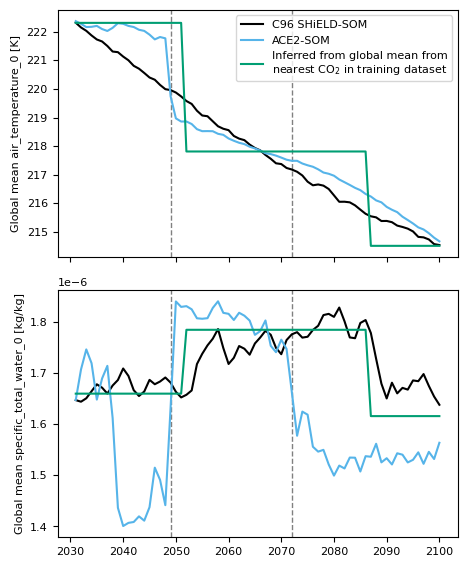

In [17]:
fig, (ax1, ax2) = faceted.faceted(
    2,
    1,
    aspect=0.618,
    width=4.5,
    sharey=False,
)

ds.sel(model=REFERENCE)["air_temperature_0"].plot(ax=ax1, color="k", label="C96 SHiELD-SOM")
ds.sel(model=ACE2_SOM)["air_temperature_0"].plot(ax=ax1, color="C0", label="ACE2-SOM")
global_mean_reference.drop_isel(climate=2).air_temperature_0.sel(climate=co2 * 1000000, method="nearest").plot(ax=ax1, color="C2", label="Inferred from global mean from\nnearest CO$_2$ in training dataset")
ax1.set_ylabel("Global mean air_temperature_0 [K]")
ax1.set_xlabel("")
ax1.set_title("")

ds.sel(model=REFERENCE)["specific_total_water_0"].plot(ax=ax2, color="k", label="C96 SHiELD-SOM")
ds.sel(model=ACE2_SOM)["specific_total_water_0"].plot(ax=ax2, color="C0", label="ACE2-SOM")
global_mean_reference.drop_isel(climate=2).specific_total_water_0.sel(climate=co2 * 1000000, method="nearest").plot(ax=ax2, color="C2", label="Inferred from global mean from\nnearest CO$_2$ in training dataset")
ax1.legend()
ax2.set_ylabel("Global mean specific_total_water_0 [kg/kg]")
ax2.set_xlabel("")
ax2.set_title("")

for ax in (ax1, ax2):
    ax.axvline(2049, color="gray", ls="--", lw=1, zorder=0)
    ax.axvline(2072, color="gray", ls="--", lw=1, zorder=0)